## Import Libraries & Load Data

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

df = pd.read_csv('../data/cardio_train_clean.csv')

X = df.drop(columns=['cardio'])
y = df['cardio']

# Split: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data loaded and split successfully!")

Data loaded and split successfully!


## Train Random Forest

In [39]:
# Initialize the model
# n_estimators=100 means we create 100 "decision trees" (100 doctors)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
print("Training Random Forest... (This might take a moment)")
rf_model.fit(X_train, y_train)
print("Training Completed!")

Training Random Forest... (This might take a moment)
Training Completed!


## Evaluation

Random Forest Accuracy: 69.66%
------------------------------
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      6405
           1       0.70      0.69      0.70      6578

    accuracy                           0.70     12983
   macro avg       0.70      0.70      0.70     12983
weighted avg       0.70      0.70      0.70     12983



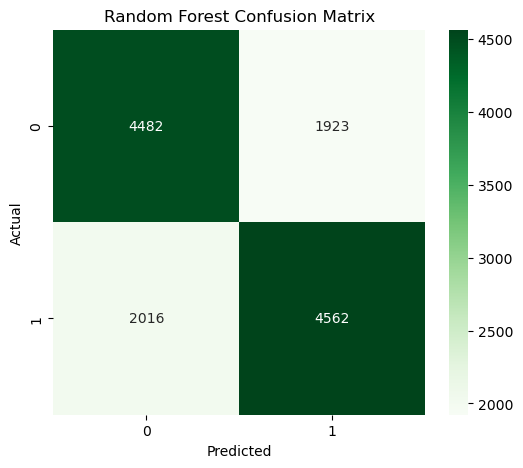

In [41]:
# Predict on Test Data
rf_predictions = rf_model.predict(X_test)

# Calculate Accuracy
rf_acc = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_acc * 100:.2f}%")

print("-" * 30)

# Detailed Report
print(classification_report(y_test, rf_predictions))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [42]:
# Save the Random Forest model to the app folder
# Note: If you do this, you must slightly update app.py (see note below)
import pickle
with open('../backend/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("Random Forest model saved as '../backend/rf_model.pkl'")

Random Forest model saved as '../backend/rf_model.pkl'


## Hyperparameter Tuning

In [44]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Define the grid of hyperparameters to test
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of trees
    'max_depth': [None, 10, 20, 30],        # How deep each tree can grow
    'min_samples_split': [2, 5, 10],        # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples at a leaf node
    'bootstrap': [True, False]              # Method of selecting samples
}

# 2. Initialize the random search
# n_iter=50 means it will try 50 random combinations (faster than checking ALL)
rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), 
                               param_distributions=param_grid, 
                               n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

# 3. Fit the random search model
print("Tuning hyperparameters... (This may take 1-2 minutes)")
rf_random.fit(X_train, y_train)

# 4. Print the best parameters
print(f"Best Parameters found: {rf_random.best_params_}")

# 5. Evaluate the optimized model
best_model = rf_random.best_estimator_
best_acc = accuracy_score(y_test, best_model.predict(X_test))
print(f"Optimized Accuracy: {best_acc * 100:.2f}%")

Tuning hyperparameters... (This may take 1-2 minutes)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters found: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}
Optimized Accuracy: 73.55%


In [45]:
# Save the Random Forest model to the app folder
# Note: If you do this, you must slightly update app.py (see note below)
import pickle
with open('../backend/best_rf_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Random Forest model saved as '../backend/best_rf_model.pkl'")

# 1. GET THE EXACT COLUMN ORDER FROM TRAINING
cols = X_train.columns.tolist()

print("The Model was trained on these columns in this EXACT order:")
print(cols)


with open('../backend/columns.pkl', 'wb') as f:
    pickle.dump(cols, f)
print("columns.pkl saved to backend folder!")

Random Forest model saved as '../backend/best_rf_model.pkl'
The Model was trained on these columns in this EXACT order:
['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years', 'bmi', 'pulse_pressure']
columns.pkl saved to backend folder!


## Use "XGBoost" (The Professional Choice)

In [47]:
from xgboost import XGBClassifier

# Initialize XGBoost
# use_label_encoder=False removes a warning
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100)

# Train
xgb_model.fit(X_train, y_train)

# Predict
xgb_predictions = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_predictions)

print(f"XGBoost Accuracy: {xgb_acc * 100:.2f}%")

XGBoost Accuracy: 73.43%


C:\Users\LENOVO\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:31:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [48]:
import pickle
with open('../backend/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("XGBoost model saved as '../backend/xgb_model.pkl'")

XGBoost model saved as '../backend/xgb_model.pkl'


In [49]:
im_value=best_model.feature_importances_
feature_data = [{'name': col, 'value': round(float(val), 3)} 
                        for col, val in zip(cols, im_value)]
feature_data

[{'name': 'gender', 'value': 0.004},
 {'name': 'height', 'value': 0.017},
 {'name': 'weight', 'value': 0.033},
 {'name': 'ap_hi', 'value': 0.367},
 {'name': 'ap_lo', 'value': 0.19},
 {'name': 'cholesterol', 'value': 0.088},
 {'name': 'gluc', 'value': 0.011},
 {'name': 'smoke', 'value': 0.004},
 {'name': 'alco', 'value': 0.003},
 {'name': 'active', 'value': 0.005},
 {'name': 'age_years', 'value': 0.106},
 {'name': 'bmi', 'value': 0.042},
 {'name': 'pulse_pressure', 'value': 0.131}]